In [6]:
import numpy
import requests
import matplotlib.pyplot as plt


Matplotlib is building the font cache; this may take a moment.


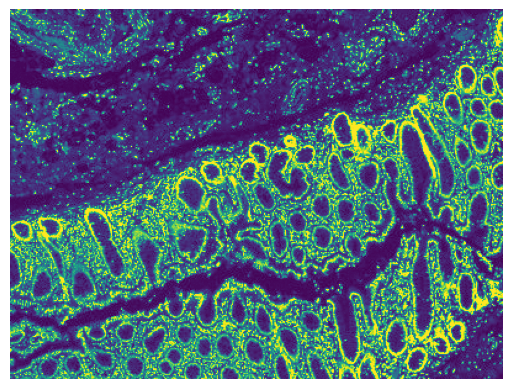

In [7]:
import requests
import matplotlib.pyplot as plt
import io

# URL of the image
url = "https://imswitch.openuc2.com/RecordingController/snapNumpyToFastAPI?resizeFactor=1"

# Fetch the image
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Read image data into a bytes object
    image_data = io.BytesIO(response.content)
    
    # Display the image using matplotlib
    img = plt.imread(image_data, format='png')
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()
else:
    print(f"Failed to retrieve image, status code: {response.status_code}")


<class 'ModuleNotFoundError'>: No module named 'ipywidgets'

In [11]:

def abssqr(x):
    # this is what a detector sees (only intensities)
    return np.real(x*np.conj(x))

def FT(x):
    # this only defines the correct fwd fourier transform including proper shift of the frequencies
    return np.fft.fftshift(np.fft.fft2(x)) # Fourier transform and shift

def iFT(x):
    # this only defines the correct inverse fourier transform including proper shift of the frequencies
    return np.fft.ifft2(np.fft.ifftshift(x)) # inverse Fourier transform and shift
    
def FresnelPropagator(E0, ps, lambda0, z):
    # Freespace propagation using Fresnel-kernel
    #
    # Inputs: 
    #             E0 - initial complex field in x-y source plane
    #             ps - pixel size in microns
    #             lambda0 - wavelength in nm
    #             z - z-value (distance from sensor to object)
    #             background - optional background image to divide out from
    #                
    # Outputs:
    #             Ef - Propagated output-field
    #             H - Fresnel Kernel
    
    upsample_scale = 1;                 # Scale by which to upsample image
    n = upsample_scale * E0.shape[1] # Image width in pixels (same as height)
    grid_size = ps * n;                 # Grid size in x-direction
    

    # Inverse space
    fx = np.linspace(-(n-1)/2*(1/grid_size), (n-1)/2*(1/grid_size), n)
    fy = np.linspace(-(n-1)/2*(1/grid_size), (n-1)/2*(1/grid_size), n)
    Fx, Fy = np.meshgrid(fx, fy)
    
    # Fresnel kernel / point spread function h = H(kx, ky)
    # from Fourier Optics, chapter 4
    # H = sqrt(z*lambda0)*exp(1i*pi*lambda0*z*(Fx.^2+Fy.^2));
    # sphere=exp(i*k/2/zc*(xx.^2+yy.^2));
    H = np.exp(1j*(2 * np.pi / lambda0) * z) * np.exp(1j * np.pi * lambda0 * z * (Fx**2 + Fy**2))
    #H= cos(pi*lambda0*z*(Fx.^2+Fy.^2)+(2*pi*z)/lambda0)+1i.*sin(pi*lambda0*z*(Fx.^2+Fy.^2)+(2*pi*z)/lambda0);
    
    # Compute FFT centered about 0
    E0fft = FT((E0));     # Centered about 0 since fx and fy centered about 0
    
    # Multiply spectrum with fresnel phase-factor
    G = H * E0fft
    Ef = iFT(G) # Output after deshifting Fourier transform
    
    return Ef#, H


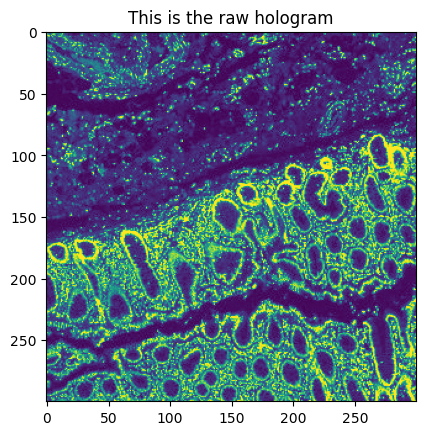

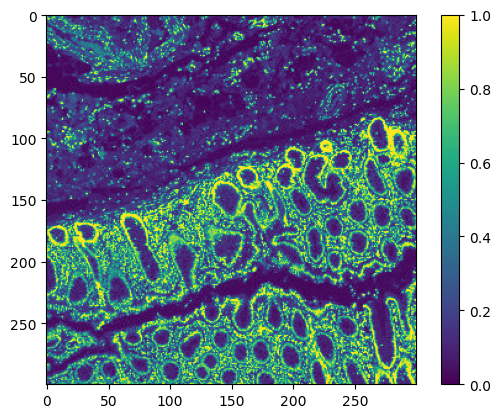

In [17]:
import numpy as np 
# define acquisition parameters
pixelsize = 1.4e-6; #0.6e-6#.2e-6#3.000e-6;
lambda0 = 440e-9; # in nanometer #530e-9;
mychannel = -1
# start and stop z-focus measure
stepsize = 0.001;

# read the raw-hologram
mDim = np.min(img.shape)
myholo = img[:mDim, :mDim]
                      

# Display the raw hologram
plt.title('This is the raw hologram'), plt.imshow(myholo), plt.show()
# crop out the ROI around the center to speed up computation (RADIX 2 please!)
holosize = myholo.shape
# display intermediate result 
plt.imshow(myholo)
plt.colorbar()
plt.show()

# normalize hologram
myholo = myholo/np.max(myholo);

# estimate hologram's amplitude
myamplitude = np.sqrt(myholo); 




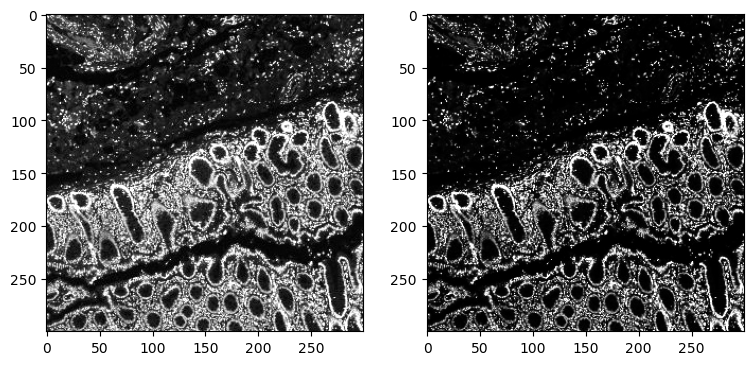

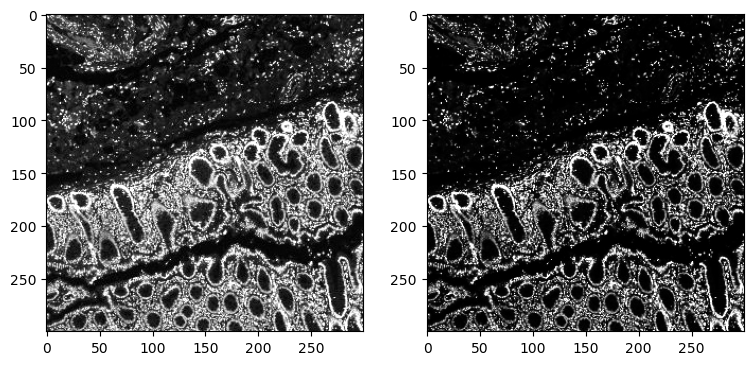

In [21]:
j = 0;
zpos = .00
# Generate a display
fig = plt.figure(figsize=(9, 6))
ax_orig = fig.add_subplot(121) 
ax_new = fig.add_subplot(122)

ax_orig.imshow(myholo, cmap="gray")
ax_new.imshow(myholo, cmap="gray")

Ef = FresnelPropagator(myholo, pixelsize, lambda0, zpos)
If = abssqr(Ef)
ax_new.imshow(If, cmap="gray")
fig.canvas.draw()
display(fig)


